# **MetaboTandem**

# A. Data Pre-processing

# 2. Pre-processing using XCMS

This Notebook allows the preprocessing of the LC-MS/MS data. 
Pre-processing in untargeted metabolomics experiments aims at quantifying the signal from individual ion species in a data set. It consists of 3 main steps: 
- **Chromatographic peak detection**
- **Alignment**
- **Correspondence** 

The resulting matrix of feature abundances can then be used as an input in downstream analyses.


## 2.1 Load libraries

In [1]:
library(xcms)
library(tidyverse)
library(ggpubr)

source("https://raw.githubusercontent.com/jorainer/xcms-gnps-tools/master/customFunctions.R")
# Modified function to write the feature name as the title of each MS2
source('modified_writeMgfData.R')

Loading required package: BiocParallel

Loading required package: MSnbase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welco

## 2.1 User inputs required <====

#### a. Pre-loaded LC-MS/MS data
Please enter the path to the the R object containing the LC-MS/MS data. This object can be created with the previous script `1_data_import.ipynb`


In [2]:
data_file  <- '../../data/imported_data.RData'

#### c. Variable to color
Set which variable will be used for coloring plots

In [3]:
color_by <- 'treatment'

## 2.2 Output directories

In [4]:
# Creating paths for the ouput directories
figures_dir <- file.path('..', 'figures')
tables_dir <- file.path('..', 'tables')

# Create output directories
dir.create(figures_dir, showWarnings = FALSE)
dir.create(tables_dir, showWarnings = FALSE)

## 2.2 Load data

In [5]:
load(data_file)

## 2.3 Initial data visualization

Set colors for plots.

In [6]:
# Create color palette
color_list <- get_palette(palette = 'Dark2', length(unique(as_vector(metadata[,color_by]))))
names(color_list) <- unique(as_vector(metadata[,color_by]))

# Create vector of color for plots
color_vector <- c(rep(color_list, each = 2))

Provides an initial visualization of the **total ion chromatogram (TIC)** and the **base peak chromatogram (BPC)** of your data.

In [7]:
# Extract chromatograms
tic <- chromatogram(data, aggregationFun="sum")
bpc <- chromatogram(data, aggregationFun="max")

#### Plot TIC

In [8]:
figure_file <- file.path(figures_dir, '2.1_tic.png')
png(figure_file, width = 3000, height = 2000, res = 300)
plot(tic, col = color_vector, ylab = "Intensity", xlab = "Retention Time (sec)", main = 'TIC')
legend("topright", legend = unique(as_vector(metadata[,color_by])), col = color_vector, lty=1)
dev.off()

png 
  2

#### Plot BPC

In [9]:
figure_file <- file.path(figures_dir, '2.2_bpc.png')
png(figure_file, width = 3000, height = 2000, res = 300)
plot(bpc, col = color_vector, ylab="Intensity", xlab="Retention Time (sec)", main= 'BPC')
legend("topright", legend=unique(as_vector(metadata[,color_by])), col = color_vector, lty=1)
dev.off()

png 
  2

## 2.4 Chromatographic peak detection

### Testing peak detection parameters <==== User inputs required

#### Peaks for visualize the samples
Please enter ranges of masses (*m/z*) and retention times (*rt*, in seconds) for a couple of peaks to visualize how your data respond to the selected parameters

In [10]:
mzr1  <- c(300, 600)
rt1  <- c(900, 1200)

#### Parameters for peak picking

In [11]:
cwp <- CentWaveParam(
    peakwidth = c(10, 100), 
    ppm = 25,
    snthresh = 0,
    noise = 1e4,
    mzdiff = -0.001,
    prefilter = c(1, 100))

#### Testing parameters

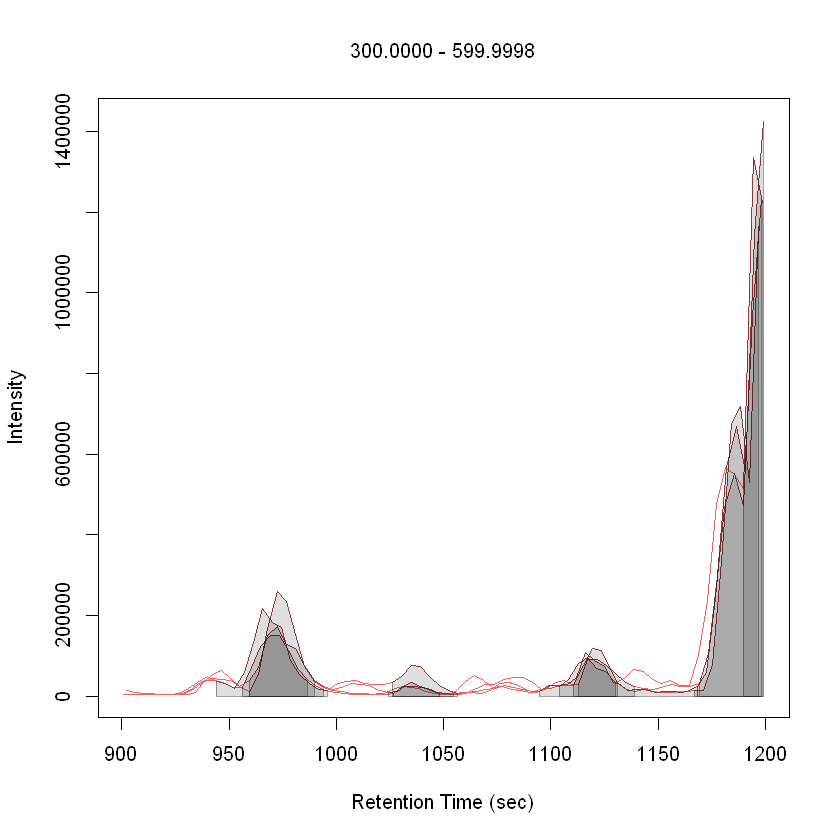

In [12]:
data %>% 
    filterRt(rt = rt1) %>% 
    filterMz(mz = mzr1) %>% 
    chromatogram(., aggregationFun="max") %>% 
      findChromPeaks(., param = cwp) %>% 
      plot(col = "indianred2", 
           ylab="Intensity", xlab="Retention Time (sec)",
           font.lab=1, cex.lab=1, cex.axis=1, font.main=1, cex.main=1)

#### Apply on full data

In [13]:
data <- findChromPeaks(data, param = cwp)


Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")

#### Extracting peak information

In [33]:
chrom_peaks_df <- as.data.frame(chromPeaks(data)) %>% 
    count(sample) %>% 
    rename('sample_index' = 'sample', 'total_peaks_detected' = 'n') %>% 
    left_join(rowid_to_column(pData(data)), by = c('sample_index' = 'rowid')) %>% 
    select(-FileName)
chrom_peaks_df
table_file <- file.path(tables_dir, '2.1_Num_detected_peaks.csv')
write_csv(chrom_peaks_df, table_file)

sample_index,total_peaks_detected,SampleID,treatment,time
<dbl>,<int>,<chr>,<chr>,<chr>
1,1189,Contro-T1,Control,T1
2,1074,Contro-TF,Control,TF
3,1207,Inoculum-T1,Inoculum,T1
4,1116,Inoculum-TF,Inoculum,TF


#### Plotting the number of detected peaks
This figure shows the number of detected peaks in each retention time bin

In [15]:
figure_file <- file.path(figures_dir, '2.3_Num_detected_peaks.png')
png(figure_file, width = 3000, height = 2000, res = 300)
colfunc <- colorRampPalette(c("lightblue", "blue4"))
par(mar=c(5,6,1,1))
plotChromPeakImage(data, 
                   binSize=100, 
                   xlab="Retention time (sec)", 
                   col = colfunc(100),
                   cex.sub = 0.5,
                   yaxt = "n")
axis(2, 
     at = seq(0,1, length.out = 4), 
     labels = pData(data)$SampleID, 
     cex.axis = 1,
     las = 2)
dev.off()

png 
  2

## 2.5 Alignment

### Testing alignment parameters <==== User inputs required
This parameters will also be used for correspondence

In [16]:
# Defining peak density parameters
pdp <- PeakDensityParam(sampleGroups = data$SampleID, 
                        bw = 30, 
                        minFraction = 0.5, 
                        minSamples = 1,
                        binSize = 0.25)

# Defining peak grouping parameters
pgp <- PeakGroupsParam(minFraction = 0.5)

#### Plot of adjusted retention time

Processing 3720 mz slices ... 
OK

Performing retention time correction using 22 peak groups.

Warning message in do_adjustRtime_peakGroups(chromPeaks(object, msLevel = msLevel), :
"Span too small for 'loess' and the available number of peak groups, resetting to 0.36"
Warning message:
"Adjusted retention times had to be re-adjusted for some files to ensure them being in the same order than the raw retention times. A call to 'dropAdjustedRtime' might thus fail to restore retention times of chromatographic peaks to their original values. Eventually consider to increase the value of the 'span' parameter."
Applying retention time adjustment to the identified chromatographic peaks ... 
OK



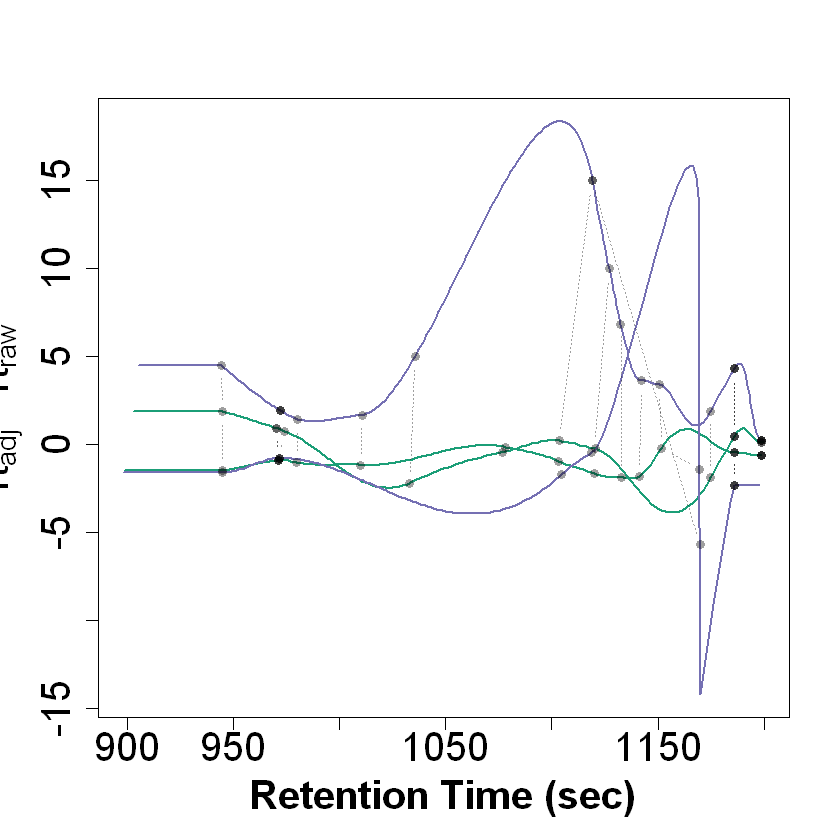

In [17]:
data %>% 
  filterRt(rt = rt1) %>% 
  groupChromPeaks(., pdp) %>% 
  adjustRtime(., param = pgp) %>% 
  plotAdjustedRtime(.,
                  col = color_vector, 
                  xlab="Retention Time (sec)", 
                  font.lab=2, cex.lab=2, cex.axis=2, 
                  font.main=2, cex.main=2, lwd=2)

In [18]:
## a - Group peaks
data <- groupChromPeaks(data, pdp)
## b - alignment
data <- adjustRtime(data, param = pgp)

Processing 6156 mz slices ... 
OK

Performing retention time correction using 396 peak groups.

Applying retention time adjustment to the identified chromatographic peaks ... 
OK



## 2.6 Correspondence

### Peak grouping parameters

In [19]:
## a - Group peaks
data <- groupChromPeaks(data, pdp)

Processing 6156 mz slices ... 
OK



## 2.7 Gap filling

Missing values occur if no chromatographic peak was assigned to a feature either because peak detection failed, or because the corresponding ion is absent in the respective sample.

In [20]:
## determine the number of missing values
number_na_i = sum(is.na(featureValues(data)))
## a - define parameter
fpp <- FillChromPeaksParam(ppm = 2, expandMz = 0.25)
## b - fill in
data <- fillChromPeaks(data, param=fpp)

Defining peak areas for filling-in .
.
.
.
 OK
Start integrating peak areas from original files

Requesting 660 peaks from Control-T1.mzXML ... got 500.

Requesting 796 peaks from Control-TF.mzXML ... got 612.

Requesting 634 peaks from Inoculum-T1.mzXML ... got 497.

Requesting 744 peaks from Inoculum-TF.mzXML ... got 506.



#### Number of peaks gap filled

In [21]:
## remaining number of na values
number_na_f = sum(is.na(featureValues(data)))
print(paste('The number of gap filled peaks was', number_na_i - number_na_f))

[1] "The number of gap filled peaks was 2115"


## 2.8 Feature Extraction

In [39]:
## extract feature values after filling in
feature_abundance_matrix <- as.data.frame(featureValues(data, value="into", method="maxint")) %>% 
    rownames_to_column(var = 'FeatureID')
## replace NA with zero
feature_abundance_matrix[is.na(feature_abundance_matrix)] <- 0
## replace file name with sample name
colnames(feature_abundance_matrix)[-1] <- paste0(metadata$SampleID, '_peak_area')

table_file <- file.path(tables_dir, '2.2_Feature_abundance_matrix.csv')
write_csv(feature_abundance_matrix, table_file)

## 2.9 Feature Definition

In [42]:
## get feature definitions and intensities
feature_definition <- as.data.frame(featureDefinitions(data)) %>% 
    rownames_to_column(var = 'FeatureID') %>% 
    select(-peakidx) %>% 
    left_join(feature_abundance_matrix, by = 'FeatureID')

table_file <- file.path(tables_dir, '2.3_Feature_definition.csv')
write_csv(feature_definition, table_file)

## 2.10 Saving Spectra information for downstream analysis

In [45]:
## spectra information of pre-processed data
## these data are useful for cloud plots
spectra_table <- fData(data) %>% 
    rownames_to_column(var = 'SpectraID')
table_file <- file.path(tables_dir, '2.4_Spectra_information.csv')
write_csv(spectra_table, table_file)

## 2.10 Extracting MS2

In [27]:
## export the individual spectra into a .mgf file
filteredMs2Spectra <- featureSpectra(data, return.type = "MSpectra", msLevel = 2)
filteredMs2Spectra <- clean(filteredMs2Spectra, all = TRUE)
filteredMs2Spectra <- formatSpectraForGNPS(filteredMs2Spectra) # this is one of the custom funtions
filteredMs2Spectra_consensus <- combineSpectra(filteredMs2Spectra, 
                                               fcol = "feature_id", 
                                               method = consensusSpectrum, 
                                               mzd = 0, 
                                               minProp = 0.5, 
                                               ppm = 25,
                                               intensityFun = median,
                                               mzFun = median)

mod_writeMgfDataFile(filteredMs2Spectra_consensus,
                          file.path('..', '..', 'data', 'ms2_spectrum_consensus.mgf'))

## 2.11 Saving pre-processed data

In [46]:
save.image(file.path('..', '..', 'data', 'xcms_processed_data.RData'))